TASK ONE A: 

In [89]:
#  Created by SHIRISH KISHORE KUMAR & SOORYA
#  Created on 04/10/2023
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim


In [90]:
#Reference:
#https://www.datascienceweekly.org/tutorials/pytorch-mnist-load-mnist-dataset-from-pytorch-torchvision
mnist_trainset = datasets.MNIST(root='./tmp/', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./tmp/', train=False, download=True, transform=None)
#Checking the length of the train and test set
print(len(mnist_trainset), len(mnist_testset))

60000 10000


In [91]:
#Setting the Hyperparameters
n_epochs = 5
batch_size_train = 32
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

#Make your network code repeatable
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

#Loading the traning data
#Reference:
#https://nextjournal.com/gkoehler/pytorch-mnist
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/mnist_data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
#Loading the test data
#Reference:
#https://nextjournal.com/gkoehler/pytorch-mnist
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/mnist_data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)
#Checking the shape of the data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


torch.Size([1000, 1, 28, 28])

In [92]:
example_targets[0:10]

tensor([9, 3, 0, 9, 5, 1, 4, 8, 0, 1])

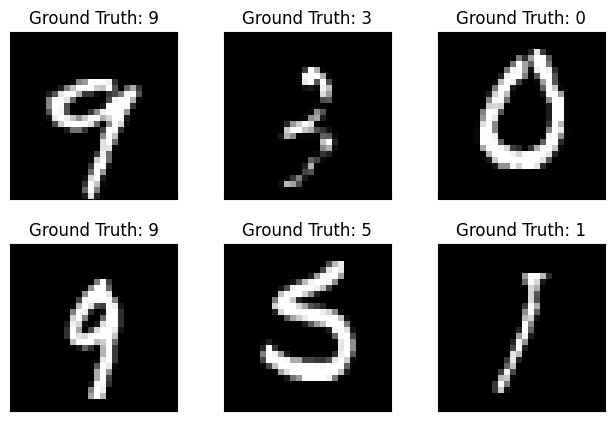

In [93]:
#Printing the first 10 images
#Reference:
#https://nextjournal.com/gkoehler/pytorch-mnist
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [94]:
#Defining the network
#Reference:
#https://nextjournal.com/gkoehler/pytorch-mnist
#Created the network as it was mentioned in the assignment
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Reference:
        #https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
        self.mnist_net =nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(10, 20, kernel_size=5),
        nn.Dropout2d(p=0.5),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(320, 50),
        nn.ReLU(),
        nn.Linear(50, 10),
        )
    def forward(self, x):
        x = self.mnist_net(x)
        return F.log_softmax(x)
    
    

In [95]:
#Creating the network
network = Net()
#Defining the optimizer
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [96]:
#Defining the variables to store the loss and counter
#Reference:
#https://nextjournal.com/gkoehler/pytorch-mnist
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
#test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]


In [97]:
#Reference:
#https://nextjournal.com/gkoehler/pytorch-mnist
#Creating the train function
def train(epoch):
  #Setting the network to train mode
  network.train()
  #Iterating through the train loader
  for batch_idx, (data, target) in enumerate(train_loader):
    #Setting the gradients to zero
    optimizer.zero_grad()
    #Forward pass
    output = network(data)
    #Calculating the loss
    loss = F.nll_loss(output, target)
    #Backward pass
    loss.backward()
    #Updating the weights
    optimizer.step()
    #Printing the loss
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/Users/shirish/trained model/model.pth')
      torch.save(optimizer.state_dict(), '/Users/shirish/trained model/optimizer.pth')

In [98]:
#Reference:
#https://nextjournal.com/gkoehler/pytorch-mnist
#Creating the test function
def test():
  #Setting the network to eval mode
  network.eval()
  #Setting the loss to zero
  test_loss = 0
  #Setting the correct predictions to zero
  correct = 0
  #Iterating through the test loader
  with torch.no_grad():
        #Iterating through the test loader
        for data, target in test_loader:
            #Forward pass
            output = network(data)
            #Calculating the loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            #Getting the prediction
            pred = output.data.max(1, keepdim=True)[1]
            #Calculating the correct predictions
            correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  #Printing the loss and accuracy
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [99]:
#Calling the train and test function
test()
#Iterating through the epochs
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/var/folders/r6/s10ql4nx4dz67qrky4s76c900000gn/T/ipykernel_17563/2816625635.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.2913, Accuracy: 732/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303162
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.313722
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.269229
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.290586
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.254803
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.220821
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.217366
Train Epoch: 1 [2240/60000 (4%)]	Loss: 2.092516
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.937167
Train Epoch: 1 [2880/60000 (5%)]	Loss: 1.826475
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.617724
Train Epoch: 1 [3520/60000 (6%)]	Loss: 1.527057
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.201073
Train Epoch: 1 [4160/60000 (7%)]	Loss: 1.200673
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.163921
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.256714
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.989360
Train Epoch: 1 [5440/60000 (9%)]	Loss: 0.858439
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.554765
Train Epoch: 1 [6080/60000 (10%)]	Los

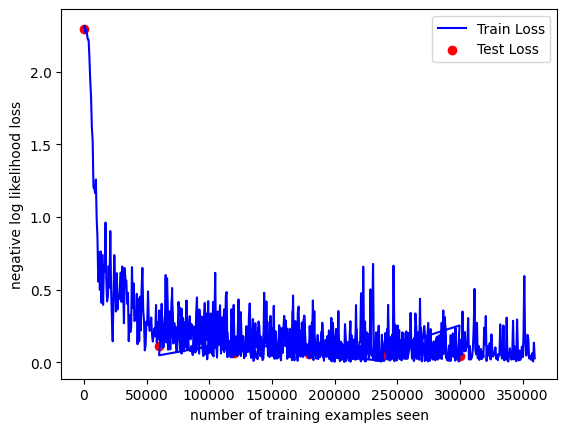

In [100]:
#Reference:
#https://nextjournal.com/gkoehler/pytorch-mnist
#Plotting the loss
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')

plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()
